<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-Data" data-toc-modified-id="Load-the-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the Data</a></span><ul class="toc-item"><li><span><a href="#Download-data-(if-needed)" data-toc-modified-id="Download-data-(if-needed)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download data (if needed)</a></span></li><li><span><a href="#Read-in-log-file" data-toc-modified-id="Read-in-log-file-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Read in log file</a></span></li><li><span><a href="#Read-in-images-by-path-from-log-file" data-toc-modified-id="Read-in-images-by-path-from-log-file-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read in images by path from log file</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Using-center-images-only" data-toc-modified-id="Using-center-images-only-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Using center images only</a></span></li></ul></li></ul></div>

In [ ]:
import pandas as pd
import numpy as np
import cv2

# Load the Data

We'll load the log data & also load the images (found in the log file).

## Download data (if needed)

In [ ]:
# Download data & unzip if it doesn't already exist
import os.path
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [ ]:
def load_ext_file(data_zip_url, data_path='data/'):
    '''Download the zip file from URL and extract it to path (if specified).
    '''
    # Check if path already exits
    if not os.path.exists(data_path):
        with urlopen(data_zip_url) as zip_resp:
            with ZipFile(BytesIO(zip_resp.read())) as zfile:
                # Extract files into the data directory
                zfile.extractall(path=None)
       

In [ ]:
# Zip file contains the "data" and "__MACOSX" directories
load_ext_file(
    'https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip',
    data_path='data/'
)

## Read in log file

In [ ]:
def create_img_meas_dfs(log_csv, data_dir=None, orig_dir=None, skiprows=None):
    '''Creates DataFrames for the image paths and measurements using CSV path.
    
    Returns tuple of two DataFrames.
    '''
    data_header = [
        'image_center',
        'image_left',
        'image_right',
        'steer_angle', # [-1,1]
        'throttle', # boolen (if accelerating)
        'break', # boolean (if breaking)
        'speed' # mph
    ]

    df = pd.read_csv(
        log_csv,
        names=data_header,
        skiprows=skiprows
    )

    # Replace the original directory from dataset (if specified)
    if orig_dir and data_dir:
        for col in ['image_center','image_left','image_right']:
            df[col] = df[col].str.replace(orig_dir,data_dir)
    
    # Get specifics for each DF
    df_img_paths = df.iloc[:,:3]
    df_measurments = df.iloc[:,3:]
    
    return df_img_paths,df_measurments

In [ ]:
df_imgs, df_meas = create_img_meas_dfs(log_csv='data/driving_log.csv',skiprows=1)

display(df_imgs.head())

print('Stats for measurements:')
display(df_meas.describe())

,image_center,image_left,image_right
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg


Stats for measurements:


,steer_angle,throttle,break,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


## Read in images by path from log file

In [ ]:
center_images = []
left_images = []
right_images = []

# TODO: Fix since this is a slow and inefficient process
# Iterate over the different images
data_dir = 'data/'
for index,row in df_imgs.iterrows():
    center_images.append(cv2.imread(data_dir+row['image_center'].strip()))
    left_images.append(cv2.imread(data_dir+row['image_left'].strip()))
    right_images.append(cv2.imread(data_dir+row['image_right'].strip()))

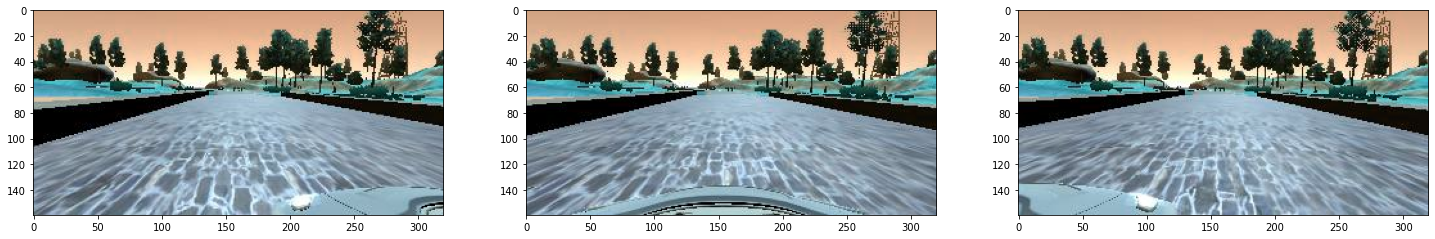

In [ ]:
# Test to see if image reading works
import matplotlib.pyplot as plt

# sub
f = plt.figure(figsize=(25,25))
ax_left = f.add_subplot(1, 3, 1)
ax_center = f.add_subplot(1, 3, 2)
ax_right = f.add_subplot(1, 3, 3)

ax_center.imshow(center_images[0])
ax_left.imshow(left_images[0])
ax_right.imshow(right_images[0])

# Model

In [ ]:
import tensorflow.keras as keras

## Using center images only

In [ ]:
# Creating a resuable default convolution
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_initializer='he_normal',
                        kernel_size=3, activation='relu', padding='SAME')

In [ ]:
input_shape = center_images[0].shape
input_shape

(160, 320, 3)

In [ ]:
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=5, input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=32),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    DefaultConv2D(filters=64),
    keras.layers.BatchNormalization(),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.BatchNormalization(),
    # Fully connected network
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1)
])

In [ ]:
model.compile(
    loss='mse', 
    optimizer='nadam', 
    metrics=['mse']
)

In [ ]:
X = np.array(center_images)
y = df_meas['steer_angle'].values.reshape(-1,1)

In [ ]:
stop_after_8_no_change = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=8,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    X,
    y, 
    epochs=30, 
    validation_split=0.2,
    callbacks=[stop_after_8_no_change],
#     verbose=1
)

Epoch 1/30
201/201 [==============================] - 25s 123ms/step - loss: 3.6892 - mse: 3.6892 - val_loss: 0.0231 - val_mse: 0.0231
Epoch 2/30
201/201 [==============================] - 24s 117ms/step - loss: 0.0787 - mse: 0.0787 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 3/30
201/201 [==============================] - 24s 117ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 4/30
201/201 [==============================] - 24s 117ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 5/30
201/201 [==============================] - 24s 117ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 6/30
201/201 [==============================] - 24s 117ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 7/30
201/201 [==============================] - 24s 117ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 8/30
201/201 [==============================] - 2

In [ ]:
def eval_model(model, model_history, X, y, show=True):
    '''
    Print accuracy score and loss for given (trained) model. Also, uses the
    model training history to plot the loss & accuracy graphs for the 
    traning and validation sets.
    '''
    score = model.evaluate(X, y)
    print(f'Accuracy: {100*score[1]:.2f}% \nLoss: {score[0]:.2f}')

    if show:
        plt.plot(model_history.history['loss'], label='Loss (training data)')
        plt.plot(model_history.history['val_loss'], label='Loss (validation data)')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.show()

        plt.plot(model_history.history['mse'], label='Accuracy (training data)')
        plt.plot(model_history.history['val_mse'], label='Accuracy (validation data)')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='lower right')
        plt.show()

252/252 [==============================] - 4s 18ms/step - loss: 0.0166 - mse: 0.0166
Accuracy: 1.66% 
Loss: 0.02


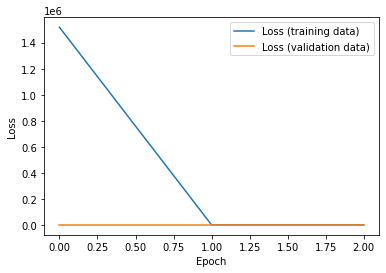

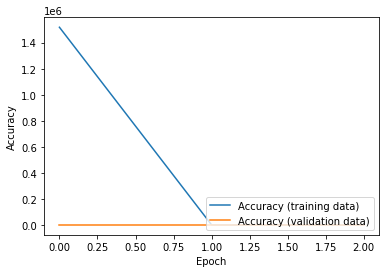

In [ ]:
eval_model(model, history, X, y)

In [ ]:
model.save('model.h5')